Shape (rows, columns): (1259, 27)
Total Number of Dimensions: 2
Total elements: 33993

 Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Timestamp                  1259 non-null   object
 1   Age                        1259 non-null   int64 
 2   Gender                     1259 non-null   object
 3   Country                    1259 non-null   object
 4   state                      744 non-null    object
 5   self_employed              1241 non-null   object
 6   family_history             1259 non-null   object
 7   treatment                  1259 non-null   object
 8   work_interfere             995 non-null    object
 9   no_employees               1259 non-null   object
 10  remote_work                1259 non-null   object
 11  tech_company               1259 non-null   object
 12  benefits 

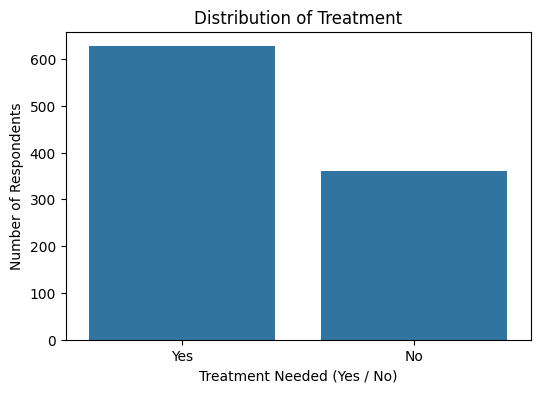

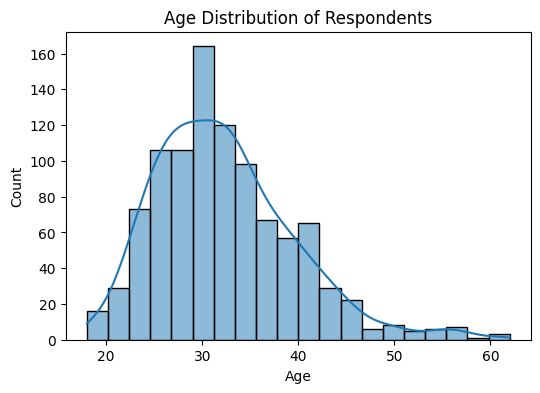

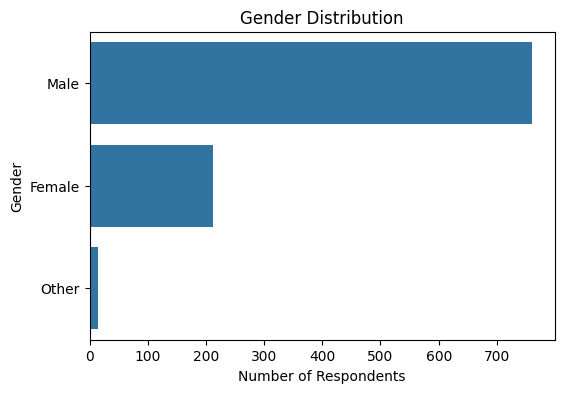

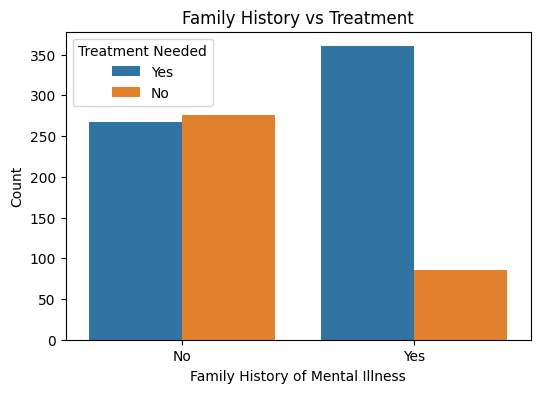

<Figure size 600x400 with 0 Axes>

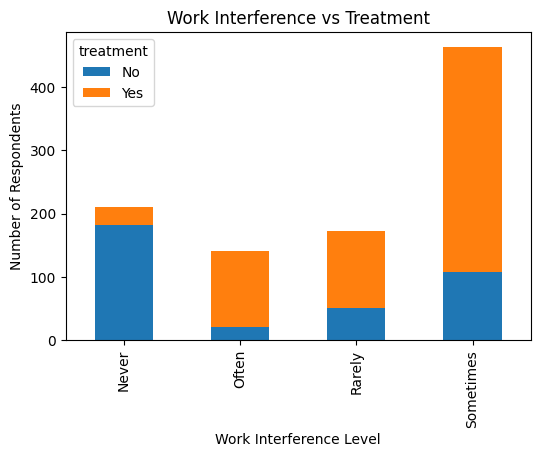

Accuracy of the Trained Model: 0.8333333333333334
              precision    recall  f1-score   support

           0       0.84      0.63      0.72        67
           1       0.83      0.94      0.88       131

    accuracy                           0.83       198
   macro avg       0.84      0.78      0.80       198
weighted avg       0.83      0.83      0.83       198



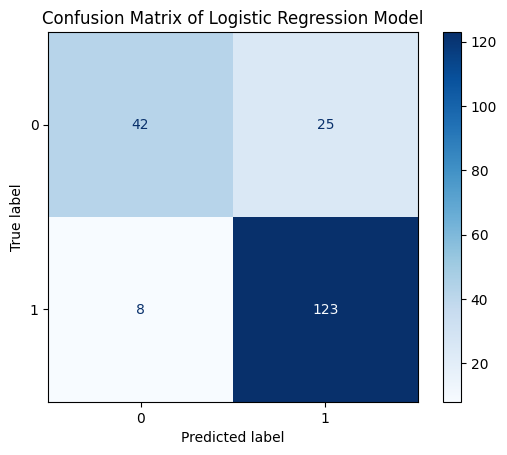

The Trained - Model, Scaler and Encoder are saved as pickle files


In [40]:
# ==============================================================================
# 1. Importing the Necessary and Important Libraries for Training The Model
# ==============================================================================
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# ==============================================================================
# 2. Loading the OSMI Mental Health Dataset that we downloaded from Kaggle
# ==============================================================================
df = pd.read_csv("survey.csv")

#===============================================================================
# 3. Checking Information and Details for the OSMI Mental Health Loaded Dataset
#===============================================================================
print("Shape (rows, columns):", df.shape)
print("================================================================")
print("Total Number of Dimensions:", df.ndim)
print("================================================================")
print("Total elements:", df.size)
print("================================================================")
print("\n Dataset Information:")
df.info()
print("================================================================")

print("\n The First 5 rows in the Data Frame:")
print(df.head())
print("================================================================")
print("\n Missing values per column:")
print(df.isnull().sum())
print("================================================================")
print("\n Unique value counts per column:")
print(df.nunique())
print("================================================================")
print("\n Target distribution (treatment):")
if "treatment" in df.columns:
    print(df["treatment"].value_counts(normalize=True))
print("================================================================")
print("\n Duplicate rows:", df.duplicated().sum())
print("================================================================")
print("\n Numerical summary stats:")
print(df.describe())
print("================================================================")

# ==============================================================================
# 4. Dropping the Unnecessary and Irrelevant Columns to Remove the Noisy Data
# ==============================================================================
df.drop(columns=["Timestamp", "comments", "state", "Country"], inplace=True, errors="ignore")

# ==============================================================================
# 5. Removing the Rows that are Missing the Important Fields or Attribute Data
# ==============================================================================
important_cols = ["Age", "Gender", "family_history", "treatment", "work_interfere", "benefits"]
df.dropna(subset=important_cols, inplace=True)

# ==============================================================================
# 6. Filtering out the Unrealistic Ages (keeping only 18 – 65)
# ==============================================================================
df = df[df["Age"].between(18, 65)]

# ==============================================================================
# 7. Cleaning and Normalizing the Gender Attribute/Feature
# ==============================================================================
def normalize_gender(g):
    g = str(g).strip().lower()
    if g in ["male", "m", "man", "cis male", "cis man", "male (cis)", "male-ish", "mal", "malr", "make", "mail", "guy (-ish) ^_^"]:
        return "Male"
    elif g in ["female", "f", "woman", "cis female", "cis-female/femme", "female (cis)", "femake", "female (trans)", "trans woman", "trans-female"]:
        return "Female"
    else:
        return "Other"

df["Gender"] = df["Gender"].apply(normalize_gender)

# ==============================================================================
# The Data Visualization of Processed and Cleaned Data
# ==============================================================================

# Importing the Libraries and Packages required for Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1) Target Distribution (Treatment)
plt.figure(figsize=(6,4))
sns.countplot(x="treatment", data=df)
plt.title("Distribution of Treatment")
plt.xlabel("Treatment Needed (Yes / No)")
plt.ylabel("Number of Respondents")
plt.show()
print("=======================================================================")

# 2) Age Distribution
plt.figure(figsize=(6,4))
sns.histplot(df["Age"], bins=20, kde=True)
plt.title("Age Distribution of Respondents")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()
print("=======================================================================")

# 3) Gender Distribution
plt.figure(figsize=(6,4))
sns.countplot(y="Gender", data=df, order=df["Gender"].value_counts().index)
plt.title("Gender Distribution")
plt.xlabel("Number of Respondents")
plt.ylabel("Gender")
plt.show()
print("=======================================================================")

# 4) Family History vs Treatment
plt.figure(figsize=(6,4))
sns.countplot(x="family_history", hue="treatment", data=df)
plt.title("Family History vs Treatment")
plt.xlabel("Family History of Mental Illness")
plt.ylabel("Count")
plt.legend(title="Treatment Needed")
plt.show()
print("=======================================================================")

# 5) Work Interference vs Treatment
plt.figure(figsize=(6,4))
pd.crosstab(df["work_interfere"], df["treatment"]).plot(kind="bar", stacked=True, figsize=(6,4))
plt.title("Work Interference vs Treatment")
plt.xlabel("Work Interference Level")
plt.ylabel("Number of Respondents")
plt.show()
print("=======================================================================")

# ==============================================================================
# 8. Filling up the Non-critical Missing field's Data to Improve Robustness
# ==============================================================================
df.fillna("Unknown", inplace=True)

# ==============================================================================
# 9. Encoding Every Categorical Column and their Equivalent Data into Integer
# ==============================================================================
encoders = {}
for col in df.select_dtypes(include=["object"]).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

# ==============================================================================
# 10. Setting up and Assigning the Features as X & Target as Y
# ==============================================================================
X = df.drop(columns=["treatment"])
y = df["treatment"]

#===============================================================================
# 11. To Scale all the Numeric Features
#===============================================================================
scaler = StandardScaler()
X = scaler.fit_transform(X)

# ==============================================================================
# Data Visualization: Correlation Heatmap
# ==============================================================================
plt.figure(figsize=(8,6))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap of Encoded Features")
plt.show()
print("=======================================================================")

# ==============================================================================
# 12. Performing Train_Test_Split to split the data into 80(Training)/20(Testing)
# ==============================================================================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)

# ==============================================================================
# 13. Now, Training the Logistic Regression Model
# ==============================================================================
log_reg = LogisticRegression(max_iter=555)
log_reg.fit(X_train, y_train)

# ==============================================================================
# 14. Finally, Evaluating the Trained Model and Checking its Accuracy
# ==============================================================================
y_pred = log_reg.predict(X_test)
print("Accuracy of the Trained Model:", accuracy_score(y_test, y_pred))
print("=======================================================================")
print(classification_report(y_test, y_pred))

# ==============================================================================
# Data Visualization: Confusion Matrix (Model Performance)
# ==============================================================================
cm = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
display.plot(cmap="Blues")
plt.title("Confusion Matrix of Logistic Regression Model")
plt.show()

# ==============================================================================
# 15. Lastly Saving the Trained Model, the LabelEncoder & the StandardScaler
# ==============================================================================
with open("osmi_mental_health_trained_model.pkl", "wb") as f:
    pickle.dump(log_reg, f)

with open("trained_model_scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

with open("trained_model_encoders.pkl", "wb") as f:
    pickle.dump(encoders, f)

print("=======================================================================")
print("The Trained - Model, Scaler and Encoder are saved as pickle files")
